In [1]:
import json
from collections import Counter
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import plotting_setup

In [2]:
def remove_unnecessary_columns(df):
    for col in df.columns:
        if 'Unnamed' in col:
            del df[col]
            
    return df

def filter_df(df):
    df = remove_unnecessary_columns(df)
    cols = []
    counts = []
    for col in df.columns:
        cols.append(col)
        counts.append(sum(list(df[col].value_counts())))
    
    sorted_counts, sorted_cols = zip(*sorted(zip(counts, cols), reverse=True))
    
    i = 0
    for c in sorted_counts:
        if c < 10:
            break
        i += 1
    
    return df[list(sorted_cols[:i])]

In [3]:
def get_house_data():
    return pd.read_csv('/home/eitri/Documents/house_output.csv')

def get_senate_data():
    return pd.read_csv('/home/eitri/Documents/senate_output.csv')

In [4]:
def count_negative(df):
    output = []
    for col in df.columns:
        output.append([col, np.sum((df[col] < 0).values.ravel())])
    
    return output

In [5]:
def filter_for_nan(col, initial_congress=96):
    x = []
    y = []
    for i, v in enumerate(col):
        if not np.isnan(v):
            x.append(i + initial_congress)
            y.append(v)
    return x, y

In [6]:
def calculate_regression(col):
    x, y = filter_for_nan(col)
    slope, _, _, _, stderr = stats.linregress(x, y)
    
    return slope, stderr, len(x)

In [7]:
def calculate_t_value(b0, s0, n0, b1, s1, n1):
    t = (b0-b1)/np.sqrt(s0**2 + s1**2)
    dof = n0+n1-4
    
    return t, dof

In [8]:
dfHouseSubject = filter_df(get_house_data())
dfSenateSubject = filter_df(get_senate_data())

In [10]:
dfHouseTotal = pd.read_csv('/home/eitri/Documents/house_modularities.csv')
dfSenateTotal = pd.read_csv('/home/eitri/Documents/senate_modularities.csv')
del dfHouseTotal['Unnamed: 0']
del dfSenateTotal['Unnamed: 0']

In [55]:
dfHouse = pd.concat([dfHouseSubject, dfHouseTotal], axis=1)
dfHouse['All bills'] = dfHouse['MODULARITY']
dfSenate = pd.concat([dfSenateSubject, dfSenateTotal], axis=1)
dfSenate['All bills'] = dfSenate['MODULARITY']

In [12]:
def slope_t_tests(df):
    p_values = {}
    b0, s0, n0 = calculate_regression(df['MODULARITY'])
    
    for col in df:
        if col != 'MODULARITY' and col != 'CONGRESS':
            b1, s1, n1 = calculate_regression(df[col])
            t, dof = calculate_t_value(b0, s0, n0, b1, s1, n1)
            p = stats.t.sf(np.abs(t), dof)*2
            p_values[col] = p
    return p_values

In [13]:
house_p_values = slope_t_tests(dfHouse)
senate_p_values = slope_t_tests(dfSenate)

In [14]:
print(house_p_values)

{'Water resources development': 0.36020388628475875, 'Transportation and public works': 0.6931480706552882, 'Taxation': 0.14981763385479124, 'Social welfare': 0.9113476992902584, 'Science, technology, communications': 0.006582236018900379, 'Public lands and natural resources': 0.4218472798073457, 'Law': 0.033988705652861835, 'Labor and employment': 0.0029342052457582363, 'International affairs': 0.43830221208103115, 'Immigration': 0.00018097932699609568, 'Housing and community development': 0.02448493276630395, 'Health': 0.22746888993535216, 'Government operations and politics': 0.9792871912237546, 'Foreign trade and international finance': 0.296516826429722, 'Finance and financial sector': 0.04905568973271131, 'Environmental protection': 0.0010114235441129004, 'Economics and public finance': 0.6512140945497342, 'Crime and law enforcement': 0.06243914156802744, 'Commerce': 0.18448913817875112, 'Civil rights and liberties, minority issues': 0.002478852644027186, 'Armed forces and nation

In [59]:
def find_significant_values(p_values, significance_level=.05):
    binned_values = {'sig': {}, 'insig': {}}
    for k, v in p_values.items():
        if v <= significance_level:
            binned_values['sig'][k] = v
        else:
            binned_values['insig'][k] = v
    return binned_values

In [64]:
binned_house_p_values = find_significant_values(house_p_values)
binned_senate_p_values = find_significant_values(senate_p_values)

In [78]:
print(binned_house_p_values['sig'], '\n')
print(binned_house_p_values['insig'], '\n')

print(len(binned_house_p_values['sig']))
print(len(binned_house_p_values['insig']))

{'Science, technology, communications': 0.006582236018900379, 'Law': 0.033988705652861835, 'Labor and employment': 0.0029342052457582363, 'Immigration': 0.00018097932699609568, 'Housing and community development': 0.02448493276630395, 'Finance and financial sector': 0.04905568973271131, 'Environmental protection': 0.0010114235441129004, 'Civil rights and liberties, minority issues': 0.002478852644027186, 'Armed forces and national security': 0.0020104194465775664, 'Private legislation': 0.008888835115069075, 'Animals': 6.179842206344387e-08, 'Energy': 0.0003219820788683144, 'Arts, culture, religion': 0.00039689865315427163} 

{'Water resources development': 0.36020388628475875, 'Transportation and public works': 0.6931480706552882, 'Taxation': 0.14981763385479124, 'Social welfare': 0.9113476992902584, 'Public lands and natural resources': 0.4218472798073457, 'International affairs': 0.43830221208103115, 'Health': 0.22746888993535216, 'Government operations and politics': 0.979287191223

In [79]:
print(binned_senate_p_values['sig'], '\n')
print(binned_senate_p_values['insig'], '\n')

print(len(binned_senate_p_values['sig']))
print(len(binned_senate_p_values['insig']))

{'Labor and employment': 0.01855669413283318, 'Immigration': 0.048608242893177445, 'Environmental protection': 0.02149621293668728, 'Civil rights and liberties, minority issues': 0.03805622982638857, 'Armed forces and national security': 0.00441826104575263, 'Arts, culture, religion': 0.0014071475116675064} 

{'Water resources development': 0.6522469413394032, 'Transportation and public works': 0.16231285622792777, 'Social welfare': 0.06551894701073196, 'Science, technology, communications': 0.2804491090939643, 'Public lands and natural resources': 0.20122428825804017, 'Law': 0.4679948971825608, 'International affairs': 0.7668517564486053, 'Housing and community development': 0.46827122173883795, 'Health': 0.2613051141751756, 'Government operations and politics': 0.15164351314302915, 'Foreign trade and international finance': 0.8189603434522437, 'Finance and financial sector': 0.9068785719163406, 'Economics and public finance': 0.10874959991576862, 'Crime and law enforcement': 0.996673

In [81]:
def plot_modularities(df, columns, title, xlabel):
    x = list(range(96, 116))
    for col in columns:
        plt.plot(x, list(df[col]), label=col)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.xticks([100, 105, 110, 115])
#     plt.yticks([0.05, 0.10, 0.15, 0.20])
    
    plt.xlabel(xlabel)
    plt.ylabel('Modularity')
    plt.title(title)
    
    plt.legend(frameon=False, loc='upper left')
    plt.grid()
    ax.margins(x=0)
    plt.show()

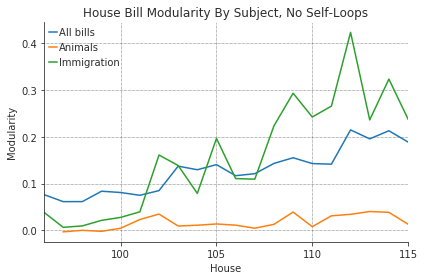

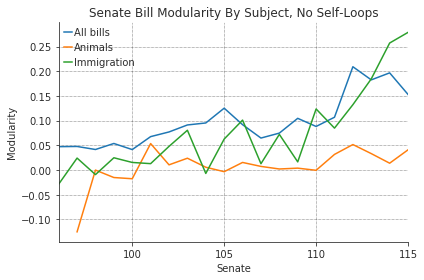

In [84]:
plot_modularities(dfHouse, ['All bills', 'Animals', 'Immigration'], 'House Bill Modularity By Subject, No Self-Loops', 'House')
plot_modularities(dfSenate, ['All bills', 'Animals', 'Immigration'], 'Senate Bill Modularity By Subject, No Self-Loops', 'Senate')

# plot_modularities(dfHouse, ['All bills', 'Arts, culture, religion'], 'House Bill Modularity By Subject, No Self-Loops', 'House')
# plot_modularities(dfSenate, ['All bills', 'Arts, culture, religion'], 'Senate Bill Modularity By Subject, No Self-Loops', 'Senate')